# EigenCAM for YOLO5

![image.png](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/yolo_eigencam.png)


In this tutorial we're going to see how to use EigenCAM (one of the gradient free methods) for YOLO5.

This is a much simpler version of the tutorial in https://github.com/jacobgil/pytorch-grad-cam/blob/master/tutorials/Class%20Activation%20Maps%20for%20Object%20Detection%20With%20Faster%20RCNN.ipynb
adapted for YOLO5.

If you wanted to use other methods like AblationCAM, you can use the other tutorial.


As a reminder from the tutorial above, we're going to use gradient free methods for object detection, since most frameworks won't support computing gradients.


We're going to use the YOLO5 model from ultralytics
``` python
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)`
```

As you recall, when adapting this library to new architectures, there are three main things you need to think about:


- **The reshape transform**. 
  This is used to get the activations from the model and process them so they are in 2D format.
  Sometimes the layers will not output tensors, for example, but tuples of tensors. 
  So we need a function that knows to dig into the output and find our 2D activation.

    In the case of YOLO5, no need for this, we're getting a 2D spatial tensor.


- **The target function** that guides our class activation map.

  In the case of EigenCAM, there is no target function. We're going to do PCA on the 2D activations.

  If we would use another method like AblationCAM we would need this, and then you can look at the faster-rcnn tutorial above.


- **The target layer** to extract the 2D activations from. We're going to use the second last layer. The last layer in YOLO5    outputs the detections, so instead we're going to use the one before it.
After printing the model and playing with it, this is in

    ```python
    model.model.model.model[-2]
    ```


First lets write some boiler plate code for doing a forward pass on the image, and displaying the detections:


In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


# image_url = "http://farm9.staticflickr.com/8134/8784387079_fe01d0d0e5_z.jpg" # sample 1
image_url = "http://farm8.staticflickr.com/7281/8731806663_9c347ffb00_z.jpg" # sample 2
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

requirements: Ultralytics requirement ['tqdm>=4.66.3'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)


Using cache found in /home/hslee/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-3-12 Python-3.11.5 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24145MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [25

TypeError: Expected state_dict to be dict-like, got <class 'models.yolo.DetectionModel'>.

Now lets create our CAM model and run it on the image:

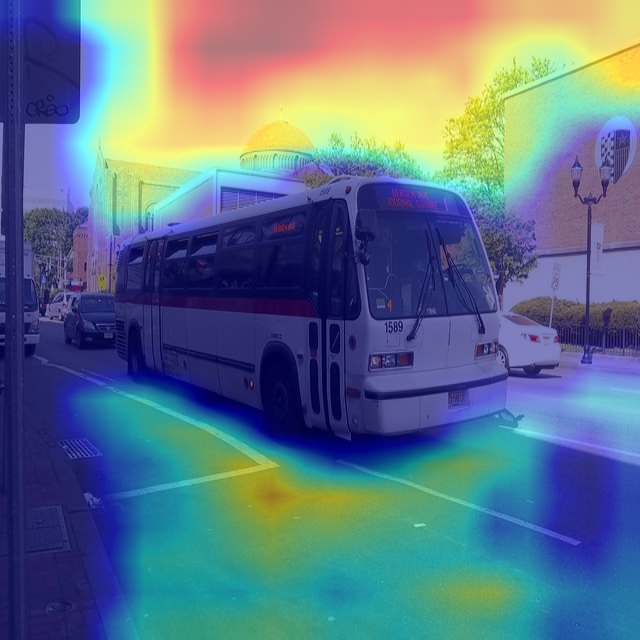

In [7]:
cam = EigenCAM(model, target_layers)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

In [8]:
from PIL import Image

# Assuming you have already defined EigenCAM and show_cam_on_image functions
cam_images = []

# Iterate over modules from index 3 to 25
for i in range(3, 24):  # 3부터 25까지
    target_layer = [model.model.model.model[i]]
    layer_name = model.model.model.model[i].__class__.__name__
    
    # Generate CAM for the current target layer
    cam = EigenCAM(model, target_layer)
    grayscale_cam = cam(tensor)[0, :, :]
    
    # Create CAM image and save it
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    
    # Save the CAM image
    cam_images.append(cam_image)
    
    # Optionally save the image to disk
    Image.fromarray(cam_image).save(f'./yolov5s/sample2/{i}_{layer_name}.png')

This contains heatmaps mainly on the dogs, but not only.

Something we can do for object detection is remove heatmap data outside of the bounding boxes, and scale the heatmaps inside every bounding box.


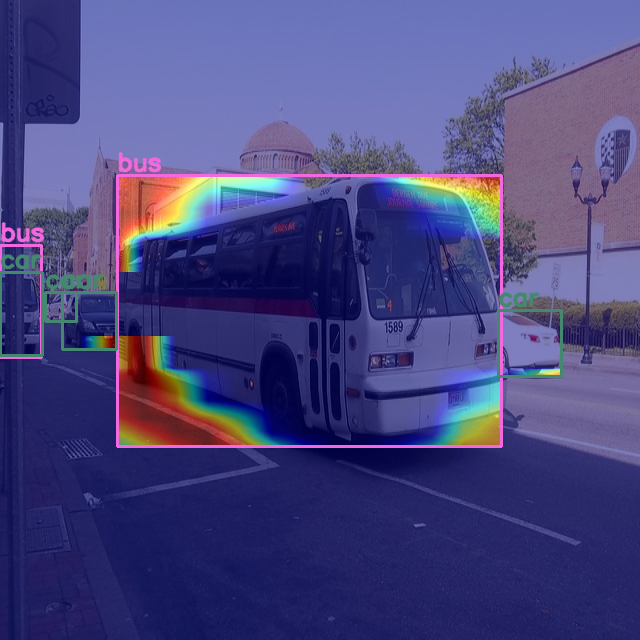

In [9]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

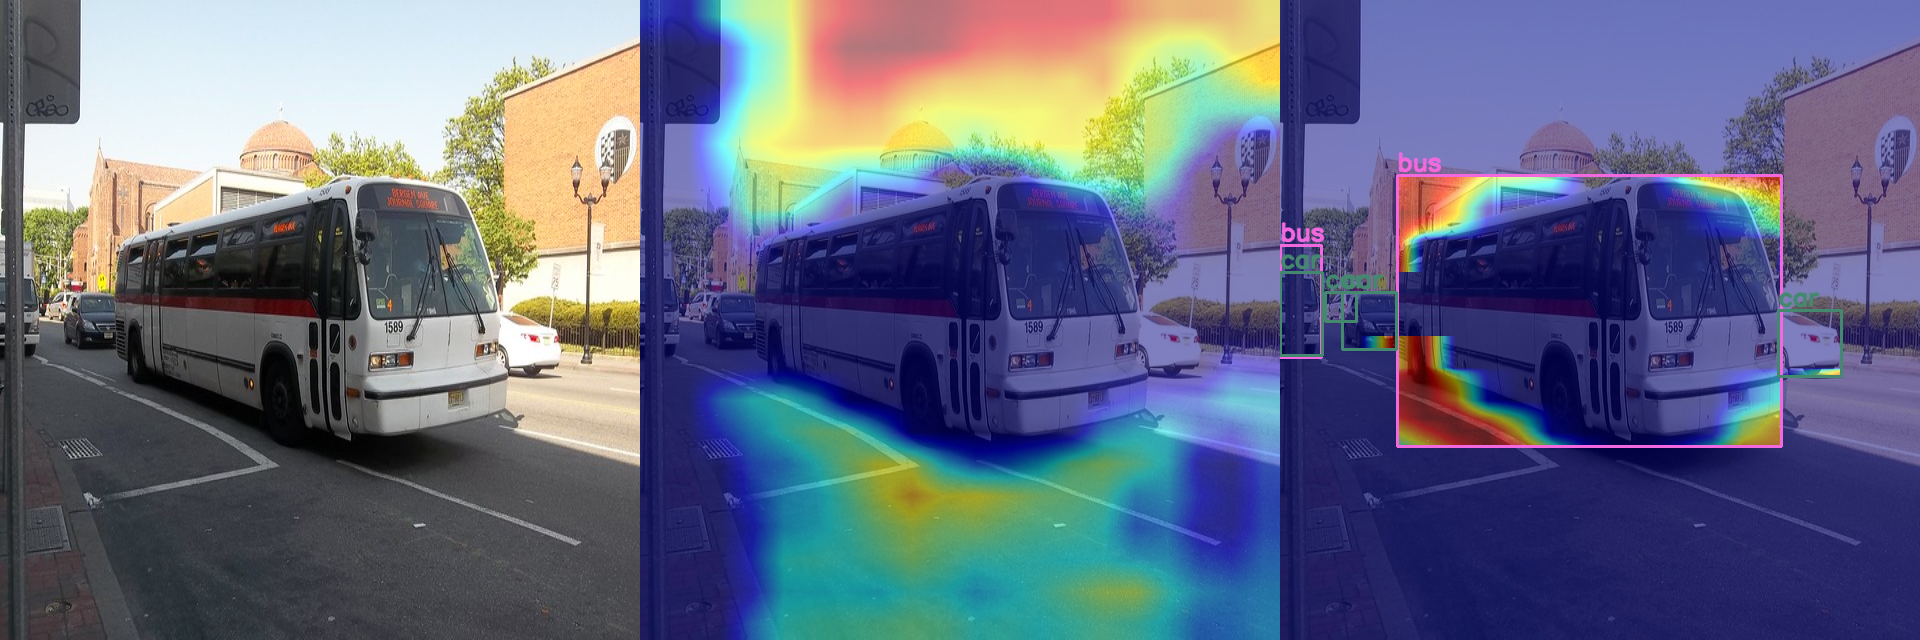

In [10]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))